In [1]:
import pyemma
import numpy as np
import glob
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import matplotlib
import matplotlib.cm as cm
import pyemma.coordinates as coor
import sys
import shutil
import os

from matplotlib import pyplot as plt
from pyemma.util.contexts import named_temporary_file
from collections import defaultdict
from itertools import product
from pandas import DataFrame
matplotlib.use('Agg')
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = 7,7
plt.rcParams['axes.linewidth'] = 2.0
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
np.set_printoptions(legacy='1.25')

## Load data

In [3]:
os.chdir('/home/cadeniran/u1/5ht/msm-tutorial')
trajfile = []
trajfile.append('md.xtc'.format())
isfile = [os.path.isfile(f) for f in trajfile]
trajfile = np.array(trajfile)[isfile]
trajfile = trajfile.tolist()
topfile = 'original.pdb'

In [4]:
#Get names of the trajectory files and topology files and save to metatrajectory
np.savez('trajectory_files.npz',files=trajfile,top=topfile)
traj_npz = np.load('trajectory_files.npz')

In [5]:
#technically unnecessary unless you are doing this step in multiple parts
trajfile = traj_npz['files'].tolist()
topfile = str(traj_npz['top'])

## Featurization

In [6]:
feat = coor.featurizer(topfile)
feat.add_minrmsd_to_ref(topfile) #minimum RMSD
region_1 = [i for i in range(178,188)] #beta pleat 8
region_2 = [i for i in range(148,158)] #beta pleat 6
pairs =[]
for i in region_1:
    for j in region_2:
        if i>j:
            pairs.append([i,j])
pairs=np.array(pairs)
feat.add_residue_mindist(pairs,periodic=False)

#minimum distance between pairs
X = coor.load(trajfile, feat)

#save trajectory with features selected
trans_obj = coor.tica(X,dim=2)
Y = trans_obj.get_output()

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


## Add secondary information

In [7]:
data = np.loadtxt('total_y.out')
extended = data[:,1]
bridge = data[:,2]
three = data[:,3]
alpha = data[:,4]
pi = data[:,5]
turn = data[:,6]
bend = data[:,7]
helix = [0]*len(pi)
for i in range(len(pi)):
    b=three[i]
    c=alpha[i]
    d=pi[i]
    helix[i]=b+c+d
other = [0]*len(pi)
for i in range(len(pi)):
    b=bridge[i]
    c=turn[i]
    d=bend[i]
    other[i]=b+c+d
helix = np.array(helix)
beta = np.array(extended)
other=np.array(other)
x=np.hstack(Y)
x.shape
Y=np.column_stack((x,helix)) 
Y = np.column_stack((Y,beta))
Y = np.column_stack((Y,other))

## Clustering

In [8]:
ncluster = 1000
clustering = coor.cluster_kmeans(Y, k=ncluster, max_iter=200)
dtrajs = clustering.dtrajs

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|                     | 0/1000 [00:00<?, ?it/s]

kmeans iterations:   0%|                                | 0/200 [00:00<?, ?it/s]

/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


## tICA Graphs with Secondary Structure Coloring

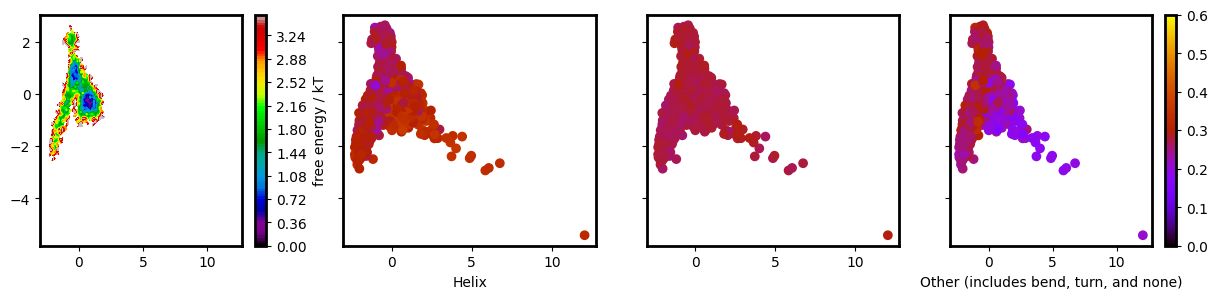

In [9]:
fig,ax=plt.subplots(1,4,figsize=(15,3), sharex=True, sharey=True)

cc_x = clustering.clustercenters[:,0] 
cc_y = clustering.clustercenters[:,1] 
pyemma.plots.plot_free_energy(np.vstack(Y)[:, 0], np.vstack(Y)[:, 1],ax=ax[0], cbar=True)

ax[1].scatter(cc_x,cc_y,c=clustering.clustercenters[:,2],cmap='gnuplot',marker='o',vmin=0,vmax=0.6)
ax[1].set_xlabel('Helix')
ax[2].scatter(cc_x,cc_y,c=clustering.clustercenters[:,3],vmin=0,vmax=0.6,cmap='gnuplot',marker='o')
c=ax[3].scatter(cc_x,cc_y,c=clustering.clustercenters[:,4],cmap='gnuplot',marker='o',vmin=0,vmax=0.6)
ax[3].set_xlabel('Other (includes bend, turn, and none)')
plt.colorbar(c,ax=ax[3])

#plt.savefig('./ss_colored.png',dpi=300)

(-3.0, 3.0)

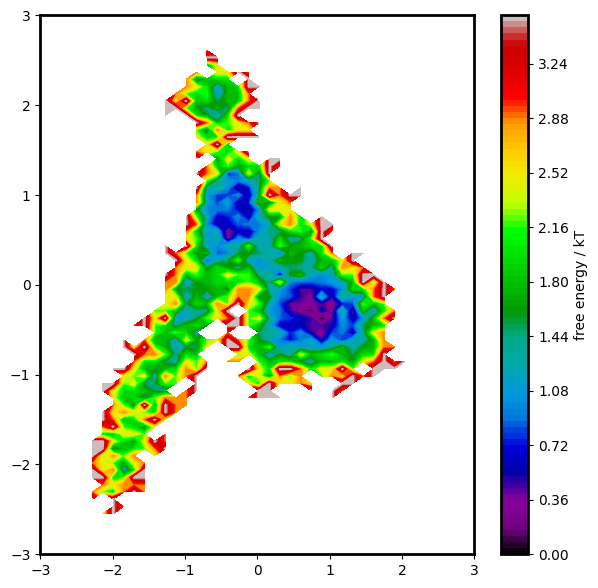

In [10]:
pyemma.plots.plot_free_energy(np.vstack(Y)[:, 0], np.vstack(Y)[:, 1], cbar=True)
plt.xlim([-3,3])
plt.ylim([-3,3])

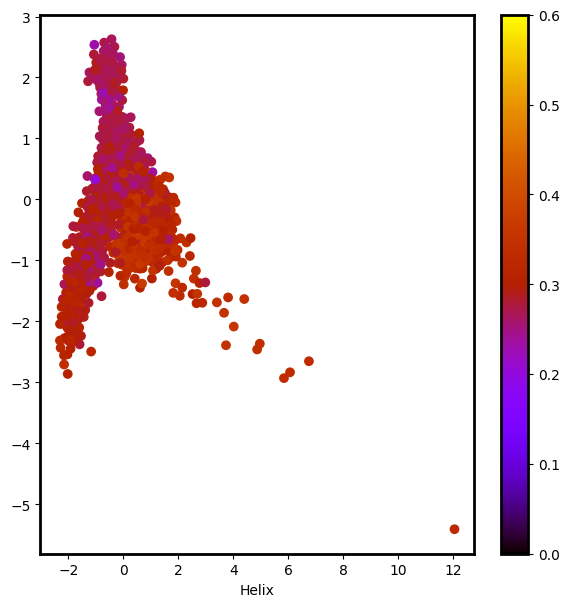

In [11]:
c=plt.scatter(cc_x,cc_y,c=clustering.clustercenters[:,2],cmap='gnuplot',marker='o',vmin=0,vmax=0.6)
plt.xlabel('Helix')
plt.colorbar(c)

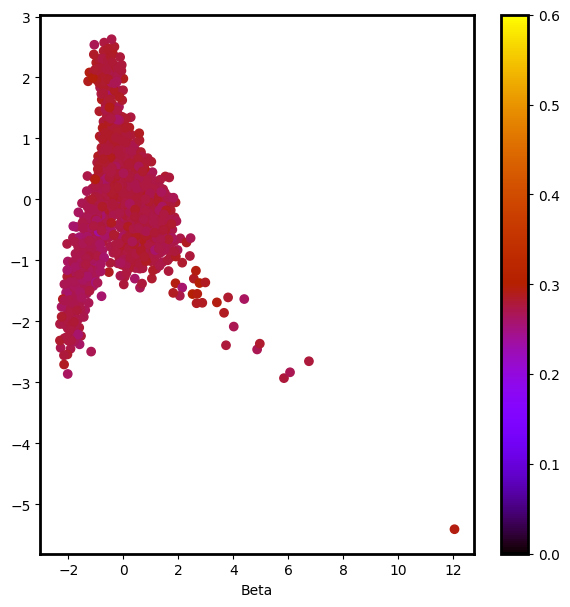

In [12]:
c=plt.scatter(cc_x,cc_y,c=clustering.clustercenters[:,3],vmin=0,vmax=0.6,cmap='gnuplot',marker='o')
plt.xlabel('Beta')
plt.colorbar(c)

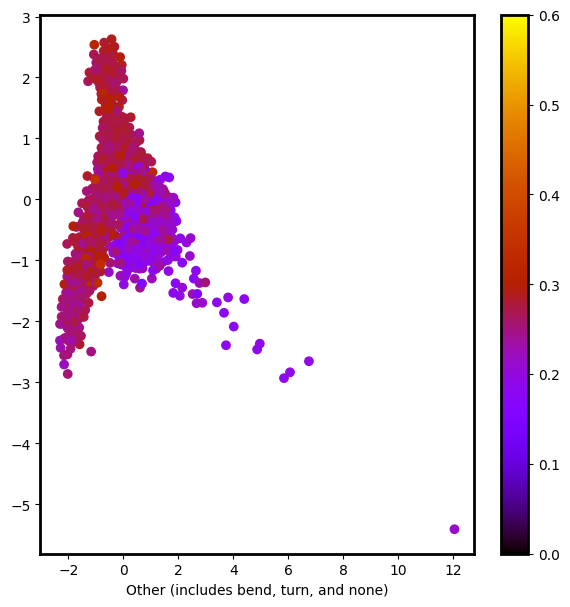

In [13]:
c=plt.scatter(cc_x,cc_y,c=clustering.clustercenters[:,4],cmap='gnuplot',marker='o',vmin=0,vmax=0.6)
plt.xlabel('Other (includes bend, turn, and none)')
plt.colorbar(c)

## Markov State Models

In [14]:
X = coor.load(trajfile, feat)
trans_obj = coor.tica(X)
Y = trans_obj.get_output()
ncluster = 1000
clustering = coor.cluster_kmeans(Y, k=ncluster, max_iter=200)
dtrajs = clustering.dtrajs

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|                     | 0/1000 [00:00<?, ?it/s]

kmeans iterations:   0%|                                | 0/200 [00:00<?, ?it/s]

/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


estimating BayesianMSM:   0%|                             | 0/4 [00:00<?, ?it/s]

26-03-25 09:45:05 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[12] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


<Axes: xlabel='lag time / step', ylabel='timescale / step'>

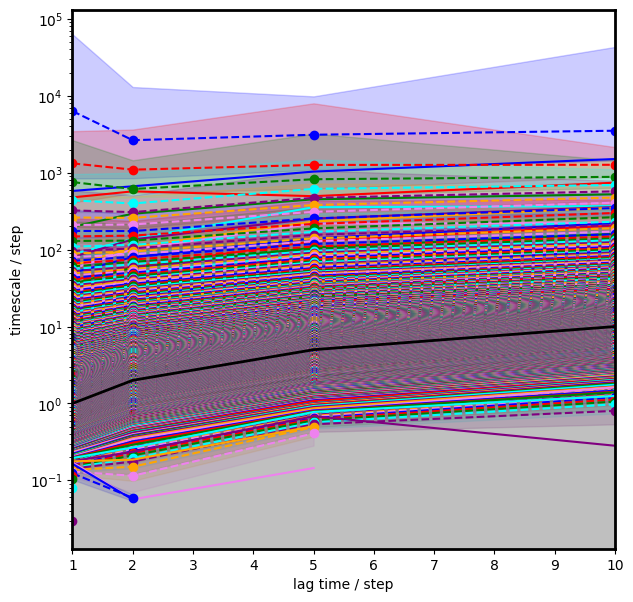

In [15]:
its = pyemma.msm.its(dtrajs, lags=[1, 2, 5, 10], errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='step')
#plt.savefig("its.png",dpi=300)

In [16]:
M = msm.estimate_markov_model(dtrajs,2)

Text(0, 0.5, 'timescale')

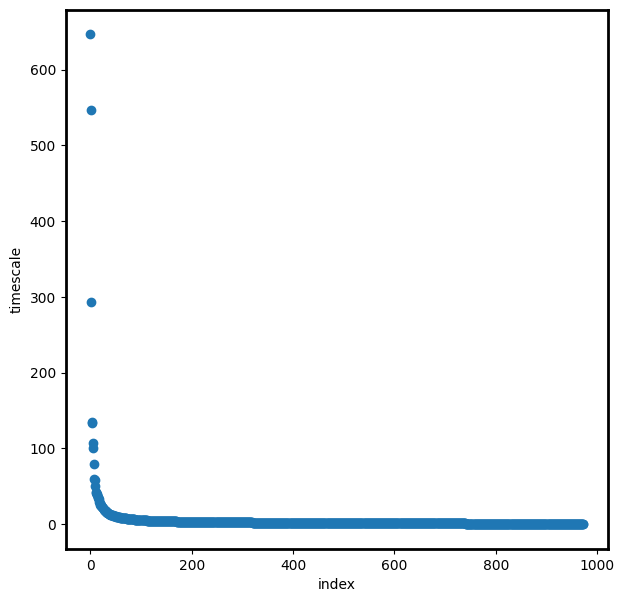

In [17]:
plt.plot(M.timescales(), linewidth=0, marker='o')
plt.xlabel('index')
plt.ylabel('timescale')
#plt.savefig('./implied_timescale_spectral_analysis.png')

estimating MaximumLikelihoodMSM:   0%|                    | 0/9 [00:00<?, ?it/s]

26-03-25 09:45:11 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[0] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 0.000000 during iteration
26-03-25 09:45:11 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[0] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 0.000000 during iteration
26-03-25 09:45:11 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[0] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 0.000000 during iteration


/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/markov/tools/analysis/_api.py:256: UserWarning: truncated eigendecomposition to contain 974 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/markov/tools/analysis/_api.py:256: UserWarning: truncated eigendecomposition to contain 973 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/markov/tools/analysis/_api.py:256: UserWarning: truncated eigendecomposition to contain 972 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/markov/tools/analysis/_api.py:256: UserWarning: truncated eigendecomposition to contain 968 components
  warnings.warn('truncated eigendecomposition t

(<Figure size 1000x1000 with 16 Axes>,
 array([[<Axes: ylabel='probability'>, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='probability'>, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='probability'>, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: xlabel='lag time (steps)', ylabel='probability'>,
         <Axes: xlabel='lag time (steps)'>,
         <Axes: xlabel='lag time (steps)'>,
         <Axes: xlabel='lag time (steps)'>]], dtype=object))

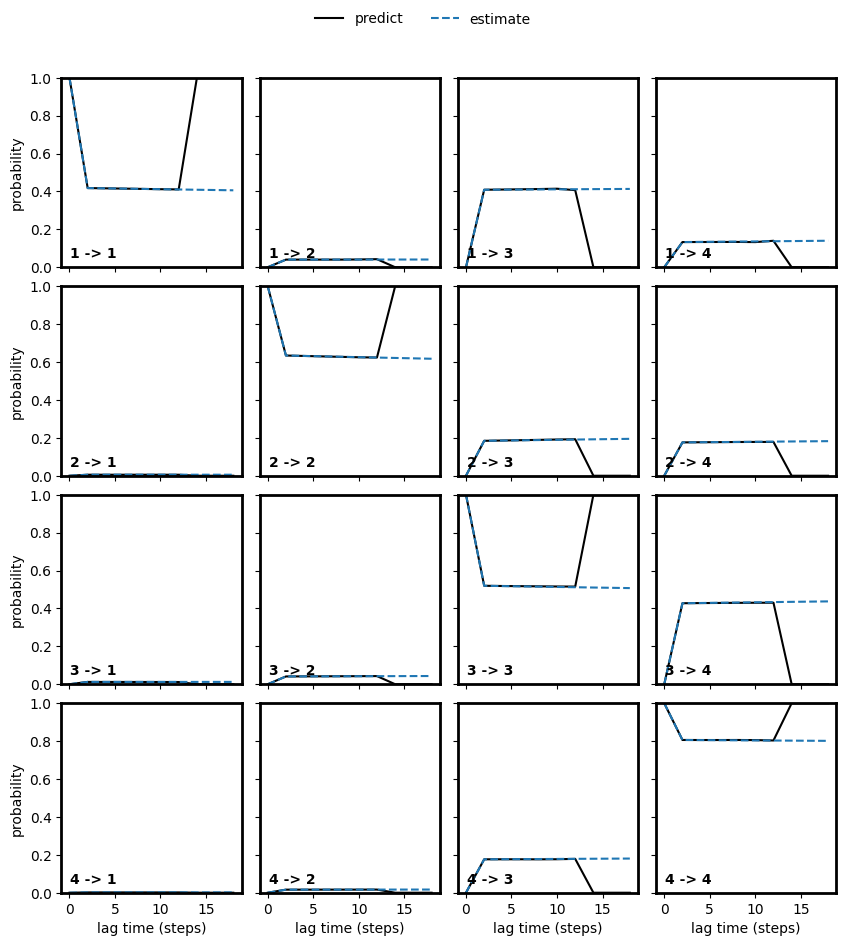

In [18]:
pyemma.plots.plot_cktest(M.cktest(4))
#plt.savefig('./cktest.png')

In [19]:
print('fraction of states used = ', M.active_state_fraction)
print('fraction of counts used = ', M.active_count_fraction)

fraction of states used =  0.975
fraction of counts used =  0.9908


In [20]:
nstates=4
M.pcca(nstates)
pcca_dist = M.metastable_distributions

In [21]:
pcca_samples = M.sample_by_distributions(M.metastable_distributions, 1)
torsions_source = pyemma.coordinates.source(trajfile, feat)
pyemma.coordinates.save_trajs(torsions_source,pcca_samples,outfiles=['pcca{}-samples.pdb'.format(n + 1) for n in range(M.n_metastable)])

['pcca1-samples.pdb',
 'pcca2-samples.pdb',
 'pcca3-samples.pdb',
 'pcca4-samples.pdb']

In [22]:
mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = M.mfpt(M.metastable_sets[i],M.metastable_sets[j])

mfpt = mfpt*100/1e6
inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]
print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1),columns=range(1, nstates + 1))

MFPT / ns:


,1,2,3,4
1,0.00,0.74,0.02,0.10
2,5.75,0.00,0.04,0.09
3,5.60,0.68,0.00,0.03
4,5.83,0.80,0.09,0.00


In [23]:
M.metastable_assignments.shape #used to figure out the splicing 
tica=Y[0]

In [24]:
Y

[array([[-2.20585251e+00, -1.63618898e+00,  4.22857702e-01, ...,
          4.01885845e-02, -3.43997851e-02,  4.96286228e-02],
        [-2.00632215e+00, -2.32170725e+00,  3.32149148e-01, ...,
         -7.46452138e-02, -1.44689664e-01, -1.11946546e-01],
        [-2.17317748e+00, -2.09061599e+00,  6.08326644e-02, ...,
         -4.00421880e-02, -2.47752905e-01, -5.27388513e-01],
        ...,
        [ 6.06527615e+00, -2.83538342e+00,  5.71732855e+00, ...,
          2.27153167e-01,  2.61458695e-01, -3.77514243e-01],
        [ 6.75393295e+00, -2.65421224e+00,  5.96599388e+00, ...,
          1.19141536e-02,  3.91633689e-01, -3.83168072e-01],
        [ 1.20529928e+01, -5.40983486e+00,  1.05347624e+01, ...,
         -2.87452161e-01,  7.96208024e-01, -7.64302194e-01]], dtype=float32)]

Text(0.5, 0, 'state 4')

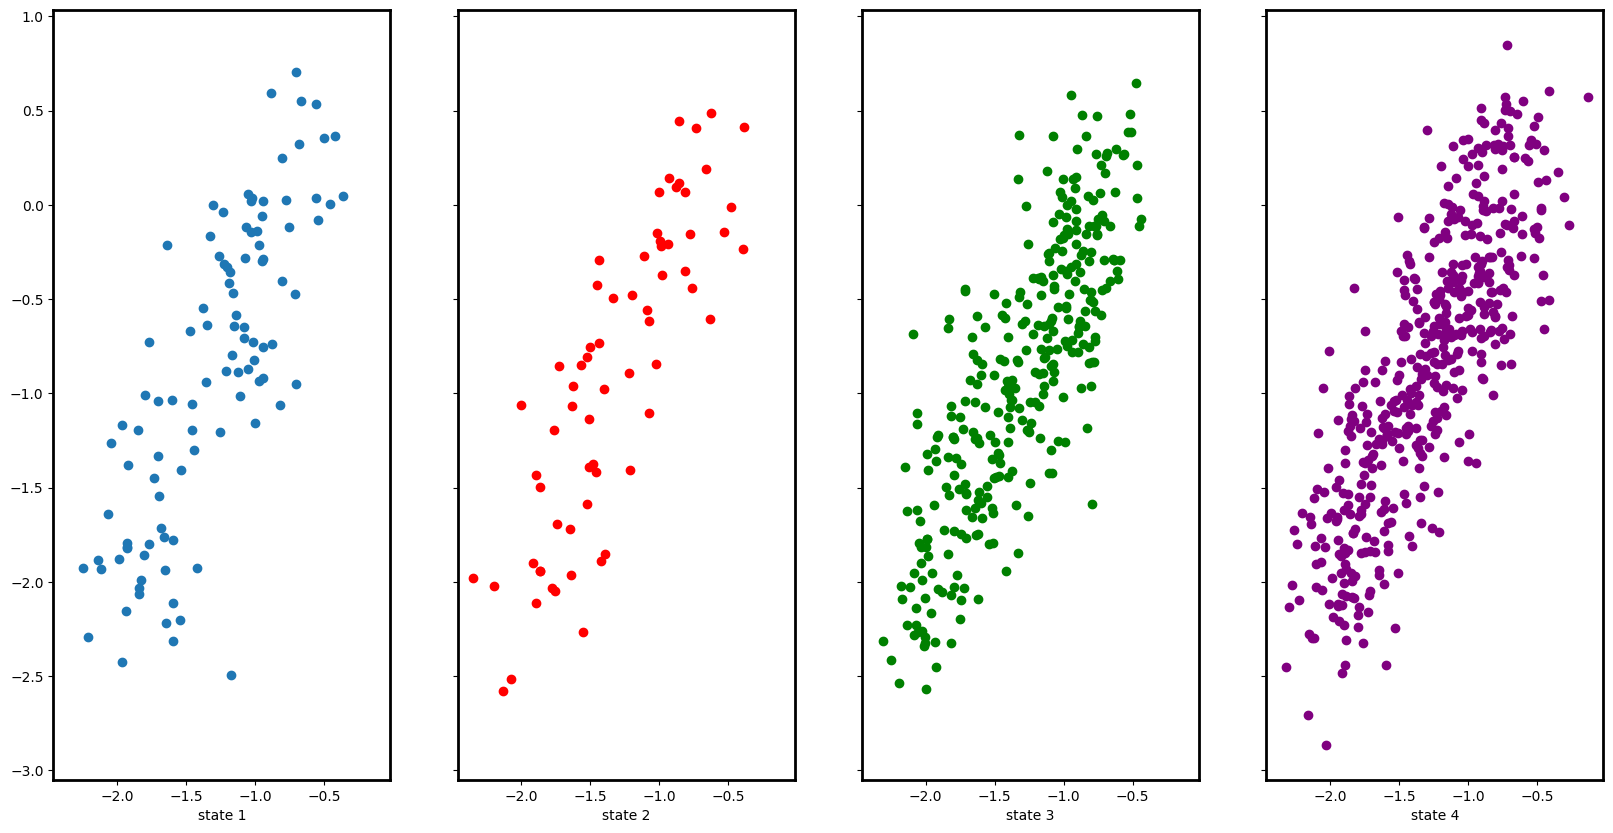

In [26]:
fig,ax=plt.subplots(1,4,figsize=(20,10), sharex=True, sharey=True)
#ax.tick_params(direction="in", bottom=False, top=False, center=False, right=False)
i=975
ax[0].scatter(tica[0:i,0][M.metastable_assignments==0],
tica[0:i,1][M.metastable_assignments==0])#the slicing was used to adjust the size
ax[0].set_xlabel('state 1',size=10)
ax[1].scatter(tica[0:i,0][M.metastable_assignments==1],
tica[0:i,1][M.metastable_assignments==1],c='red')
ax[1].set_xlabel('state 2',size=10)
ax[2].scatter(tica[0:i,0][M.metastable_assignments==2],
tica[0:i,1][M.metastable_assignments==2],c='green')
ax[2].set_xlabel('state 3',size=10)
ax[3].scatter(tica[0:i,0][M.metastable_assignments==3],
tica[0:i,1][M.metastable_assignments==3],c='purple')
ax[3].set_xlabel('state 4',size=10)
#plt.savefig('msm_cluster.png', dpi=300)

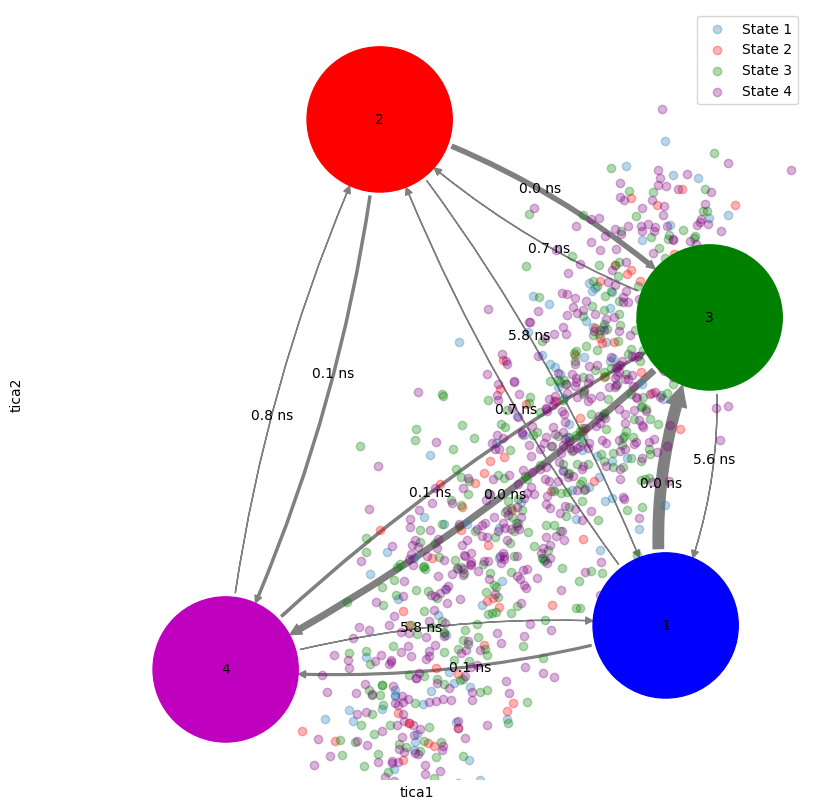

In [27]:
 #creates the transition graph
fig,ax=plt.subplots(1,1,figsize=(10,10))
tica_concatenated=np.concatenate(Y)
state_labels=['1','2','3','4']
highest_membership = M.metastable_distributions.argmax(1)
coarse_state_centers = np.array([[-.7, -1.5], [-2,.8],[-0.5,-0.1],[-2.7,-1.7]])
size = np.array([0.0005,0.0005,0.0005,0.0005])
colors=('b','r','g','m')
ax.set_xlabel('tica1')
ax.set_ylabel('tica2')
ax.set_xlim(tica_concatenated[:,0].min(), tica_concatenated[:,0].max())
ax.set_ylim(tica_concatenated[:,1].min(), tica_concatenated[:,1].max())
i=975
ax.scatter(tica[0:i,0][M.metastable_assignments==0],
tica[0:i,1][M.metastable_assignments==0],label='State 1',alpha=0.3)
ax.scatter(tica[0:i,0][M.metastable_assignments==1],
tica[0:i,1][M.metastable_assignments==1],c='red',label='State 2',alpha=0.3)
ax.scatter(tica[0:i,0][M.metastable_assignments==2],
tica[0:i,1][M.metastable_assignments==2],c='green',label='State 3',alpha=0.3)
ax.scatter(tica[0:i,0][M.metastable_assignments==3],
tica[0:i,1][M.metastable_assignments==3],c='purple',label='State 4',alpha=0.3)

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=coarse_state_centers[:,:2],
    arrow_label_format='%.1f ns',
    arrow_labels=mfpt,
    arrow_scale=1.5,
    state_colors=colors,
    state_sizes=size,
    ax=ax,
    state_labels=range(1, nstates + 1),
    size=10,alpha=1);
plt.legend()
#plt.savefig('transition_graph.png',dpi=300)